# ISA Learn Delta

**Motivation:** This is almost identical to the `ISA-Learn-Delta` notebook, except we're going to start from some weights that we _knew_ to be good from a pretrained model from `Invariant-Slot-Attention`.

In [73]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('../code')

from model import InvariantSlotAttention
from plotting import plot_chosen_slots
from data import make_batch
from torch.nn import init
from train import hungarian_matching, train

import torch
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
device='cuda:0'
hps = {
    'hidden_dim': 16,
    'k_slots':3,
    'query_dim':128,
    'pixel_mult':0.2,
    'device':device
}

In [7]:
# class HyperGraphISA(torch.nn.Module):
#     def __init__(self, 
#                  resolution=(32,32),
#                  xlow=-0.5,
#                  xhigh=0.5,
#                  varlow=0.01,
#                  varhigh=0.05,
#                  k_slots=3, 
#                  num_conv_layers=3,
#                  hidden_dim=32, 
#                  query_dim=32, 
#                  n_iter=2,
#                  pixel_mult=1,
#                  device='cpu' 
#                  ):
#         '''
#         Slot attention encoder block, block attention
#         '''
#         super().__init__()

#         self.k_slots = k_slots
#         self.hidden_dim = hidden_dim
#         self.query_dim = query_dim
#         self.n_iter = n_iter

#         self.resolution = resolution
#         self.xlow, self.xhigh = xlow, xhigh
#         self.rlow, self.rhigh = np.sqrt(varlow), np.sqrt(varhigh)
        
#         self.device=device
         
#         self.softmax_T = 1/np.sqrt(query_dim)
        
#         self.dataN = torch.nn.LayerNorm(self.hidden_dim)
#         self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        
#         self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
#         self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
#         self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)
        
#         '''
#         CNN feature extractor
#         '''
#         kwargs = {'out_channels': hidden_dim,'kernel_size': 5, 'padding':2 }
#         cnn_layers = [torch.nn.Conv2d(1,**kwargs)]
#         for i in range(num_conv_layers-1):
#             cnn_layers += [torch.nn.ReLU(), torch.nn.Conv2d(hidden_dim,**kwargs)] 
#         cnn_layers.append(torch.nn.ReLU())

#         self.CNN_encoder = torch.nn.Sequential(*cnn_layers)
            
#         # Grid + query init
#         self.abs_grid = self.build_grid()
                   
#         self.dense = torch.nn.Linear(2, query_dim) 
#         self.pixel_mult = pixel_mult # LH's proposal... but almost same as 1/delta in ISA

#         # Apply after the data normalization
#         self.init_mlp = torch.nn.Sequential(
#             torch.nn.Linear(query_dim,query_dim),
#             torch.nn.ReLU(),
#             torch.nn.Linear(query_dim,query_dim)
#         )
            
#         self.slots_mu = torch.nn.Parameter(torch.randn(1, 1, self.query_dim))
#         self.slots_logsigma = torch.nn.Parameter(torch.zeros(1, 1, self.query_dim))
#         init.xavier_uniform_(self.slots_logsigma)

#         self.init_slots = self.init_slots

        
#         '''
#         Option to add a final (x,y,r) prediction to each slot
#         '''
#         self.learn_slot_feat = True
#         if self.learn_slot_feat:
#             self.final_mlp = torch.nn.Sequential(
#                 torch.nn.Linear(query_dim,hidden_dim),
#                 torch.nn.ReLU(),
#                 torch.nn.Linear(hidden_dim, 3)
#             )
        
#     def build_grid(self):
#         '''
#         From google slot attention repo:
#         https://github.com/nhartman94/google-research/blob/master/slot_attention/model.py#L357C1-L364C53
#         '''
#         resolution = self.resolution
#         xlow, xhigh = self.xlow, self.xhigh
           
#         ranges = [np.linspace(xlow, xhigh, num=res) for res in resolution]
#         grid = np.meshgrid(*ranges, sparse=False, indexing="xy")
#         grid = np.stack(grid, axis=-1)
#         grid = np.reshape(grid, [resolution[0], resolution[1], -1])
#         grid = np.expand_dims(grid, axis=0)
        
#         grid = torch.FloatTensor( grid ).to(self.device)
#         grid = torch.flatten(grid,1,2)
    
#         return grid
                
#     def init_slots(self,Nbatch):
#         '''
#         Slot init taken from
#         https://github.com/lucidrains/slot-attention/blob/master/slot_attention/slot_attention.py
#         '''
        
#         stdhigh, stdlow = self.rlow, self.rhigh
        
#         mu = self.slots_mu.expand(Nbatch, self.k_slots, -1)
#         sigma = self.slots_logsigma.exp().expand(Nbatch, self.k_slots, -1)
    
#         queries = mu + sigma * torch.randn(mu.shape,device=device)
    
#         # Add the position and scale initialization for the local ref frame
#         ref_frame_dim = 3
#         pos_scale = torch.rand(Nbatch, self.k_slots, ref_frame_dim,device=device)

#         pos_scale[:,:2] -= 0.5
#         pos_scale[:,-1]  = (stdhigh - stdlow) * pos_scale[:,-1] + stdlow
        
#         return queries, pos_scale
     
#     def get_keys_vals(self, encoded_data, pos_scale):

#         # Get the relative position embedding
#         rel_grid = self.abs_grid.unsqueeze(1) - pos_scale[:,:,:2].unsqueeze(2)
#         rel_grid /= pos_scale[:,:,-1].unsqueeze(2).unsqueeze(-1)
        
#         # Embed it in the same space as the query dimension 
#         embed_grid = self.pixel_mult * self.dense( rel_grid )
        
#         # keys, vals: (bs, img_dim, query_dim)
#         keys = m.toK(encoded_data).unsqueeze(1) + embed_grid
#         vals = m.toV(encoded_data).unsqueeze(1) + embed_grid
        
#         keys = self.init_mlp(self.queryN(keys))
#         vals = self.init_mlp(self.queryN(vals))
        
#         return keys, vals
                
#     def attention_and_weights(self,queries,keys):
        
#         logits = torch.einsum('bse,bsde->bsd',queries,keys) * self.softmax_T
        
#         att = torch.nn.functional.softmax(logits, dim = 1)
        
#         div = torch.sum(att, dim = -1, keepdims = True)
#         wts = att/div + 1e-8
#         return att,wts

#     def update_frames(self,wts):
#         '''
#         Update the relative frame position
#         '''
        
#         # expand to include the batch dim
#         grid_exp = self.abs_grid.expand(wts.shape[0],-1,2)
        
#         new_pos = torch.einsum('bsd,bde->bse',wts,grid_exp)
        
#         new_scale = torch.sum(torch.pow(grid_exp.unsqueeze(1) - new_pos.unsqueeze(2),2),dim=-1)
        
#         new_scale = torch.einsum('bsd,bsd->bs', wts, new_scale)
#         new_scale = torch.sqrt(new_scale)
        
#         return torch.cat([new_pos,new_scale.unsqueeze(-1)],axis=-1)
        
#     def iterate(self, queries, pos_scale, encoded_data):
        
#         # Get the keys and values in the ref ref frame
#         keys, vals = self.get_keys_vals(encoded_data,pos_scale)
        
#         # att,wts: (bs, k_slots, img_dim)
#         att,wts = self.attention_and_weights(self.queryN(queries),keys)   
        
#         new_pos_scale = self.update_frames(wts)
        
#         # Update the queries with the recurrent block
#         updates = torch.einsum('bsd,bsde->bse',wts,vals) # bs, n_slots, query_dim
        
#         updates = self.gru(
#             updates.reshape(-1,self.query_dim),
#             queries.reshape(-1,self.query_dim),
#         )
        
#         return updates.reshape(queries.shape), new_pos_scale
        
#     def forward(self, data):
    
#         '''
#         Step 1: Extract the CNN features
#         '''
#         encoded_data = self.CNN_encoder(data) # Apply the CNN encoder
#         encoded_data = torch.permute(encoded_data,(0,2,3,1)) # Put channel dim at the end
#         encoded_data = torch.flatten(encoded_data,1,2) # flatten pixel dims
#         encoded_data = self.dataN(encoded_data)
        
#         '''
#         Step 2: Initialize the slots
#         '''
#         Nbatch = data.shape[0]
#         queries, pos_scale = self.init_slots(Nbatch) # Shape (Nbatch, k_slots, query_dim)
                
#         '''
#         Step 3: Iterate through the reconstruction
#         '''
#         for i in range(self.n_iter):
#             queries, pos_scale = self.iterate(queries, pos_scale, encoded_data)    
            
#         # With the final query vector, calc the attn, weights, + rel ref frames
#         keys, vals = self.get_keys_vals(encoded_data,pos_scale)
#         att, wts = self.attention_and_weights(self.queryN(queries),keys)   
#         new_pos_scale = self.update_frames(wts)
                
#         if self.learn_slot_feat:
#             slot_feat = self.final_mlp(queries)
            
#             # Want to learn the delta from the previously estimated position
#             slot_feat += new_pos_scale
            
#             return queries, att, slot_feat 
        
#         else:
#             return queries, att, wts

In [8]:
# m = HyperGraphISA(**hps).to(device)
m = InvariantSlotAttention(**hps).to(device)

In [18]:
cID_prev = 'isa-cosine-decay'
lastIter = 39_000
modelToLoad = f'../code/models/{cID_prev}/m_{lastIter}.pt'
m.load_state_dict(torch.load(modelToLoad,map_location=device),strict=False)

_IncompatibleKeys(missing_keys=['final_mlp.0.weight', 'final_mlp.0.bias', 'final_mlp.2.weight', 'final_mlp.2.bias'], unexpected_keys=[])

In [10]:

# Invaraint Slot Attention, Hyper Graph, warm start
cID = 'isa-hg-warm'

modelDir = f'../code/models/{cID}'
figDir = f'../code/figures/{cID}'


In [14]:
def train(model, 
          Ntrain = 5000, 
          bs=32, 
          lr=3e-4,
          warmup_steps=5_000,
          alpha=1,
          losses = {'tot':[],'bce':[],'mse':[]},
          kwargs={'isRing': True, 'N_clusters':2},
          device='cpu',
          plot_every=250, 
          save_every=1000,
          color='C0',cmap='Blues',
          modelDir='.',figDir='',showImg=True):
    '''
    train -- arguments copied from Lukas's fct (see train.py)
    '''

    # Learning rate schedule config
    base_learning_rate = lr
    
    opt = torch.optim.Adam(model.parameters(), base_learning_rate)
    model.train()
    
    k_slots = model.k_slots
    max_n_rings = kwargs['N_clusters']
    resolution = model.resolution
    kwargs['device'] = device

    start = len(losses)
    for i in range(start,start+Ntrain):

        learning_rate = base_learning_rate * 0.5 * (1 + np.cos(np.pi * i / Ntrain))
        if i < warmup_steps:
            learning_rate *= (i / warmup_steps)
        
        opt.param_groups[0]['lr'] = learning_rate
        
        X, Y, mask = make_batch(N_events=bs, **kwargs)
        
        queries, att, Y_pred = model(X)
         
        # Reshape the target mask to be flat in the pixels (same shape as att)
        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      
        with torch.no_grad():
            
            pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
            indices = hungarian_matching(pairwise_cost)

        # Apply the sorting to the predict
        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        # Loss calc
        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()
        
        Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean()
    
        # Calculate the loss
        li = l_bce + alpha*l_mse
        
        li.backward()
        clip_val=1
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_val)
        
        opt.step()
        opt.zero_grad()

        losses['tot'].append(float(li))
        losses['bce'].append(float(l_bce))
        losses['mse'].append(float(l_mse))
        
        if i % plot_every == 0:
            print('iter',i,', loss',li.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])  
            iEvt = 0

            # losses, mask, att_img, Y_true, Y_pred
            plot_chosen_slots(losses,
                              mask[iEvt].sum(axis=0), 
                              slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                              Y_true_sorted[iEvt],
                              Y_pred_sorted[iEvt])
            
        if (i % save_every == 0) and modelDir:
            torch.save(model.state_dict(), f'{modelDir}/m_{i}.pt')
            with open(f'{modelDir}/loss.json','w') as f:
                json.dump(losses, f)

    model.eval()
    return model,losses

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([256, 1, 2, 3])) that is different to the input size (torch.Size([256, 3, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


iter 100 , loss 0.21928339 , lr 2.997040092642407e-05


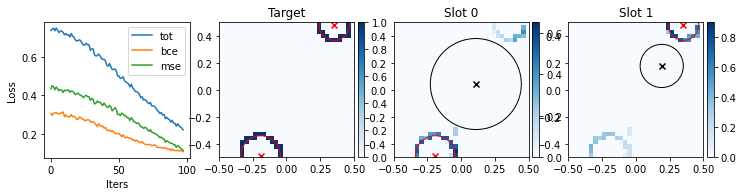

iter 200 , loss 0.11906141 , lr 5.976344103943434e-05


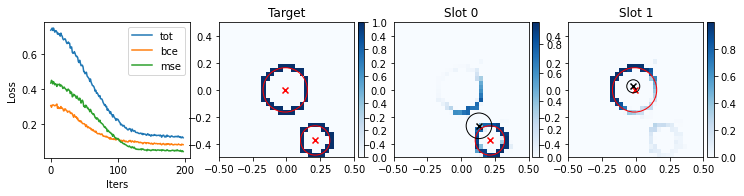

iter 300 , loss 0.103104 , lr 8.920292628279099e-05


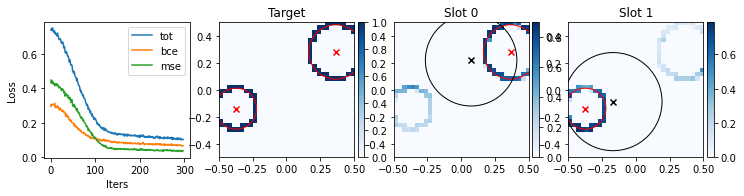

iter 400 , loss 0.09058714 , lr 0.00011811498966771785


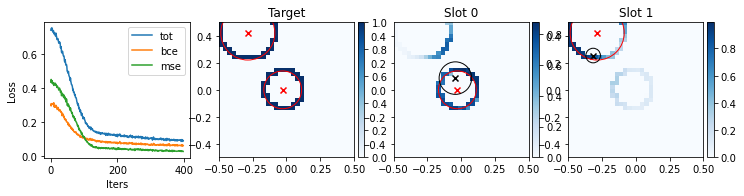

iter 500 , loss 0.08301388 , lr 0.00014632923872213652


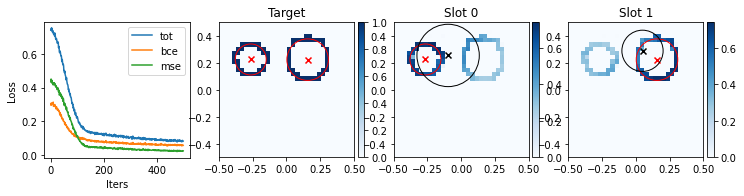

iter 600 , loss 0.07586438 , lr 0.0001736798837299426


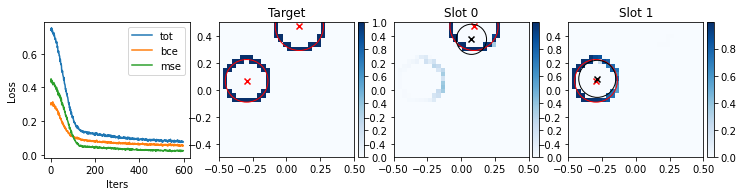

iter 700 , loss 0.070192315 , lr 0.00020000684050893204


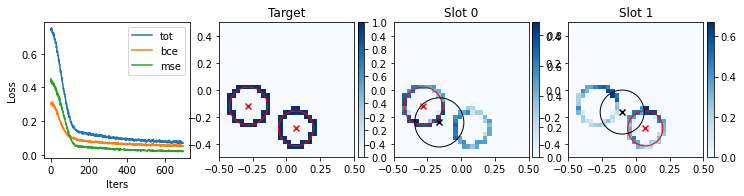

iter 800 , loss 0.070104495 , lr 0.00022515680160526362


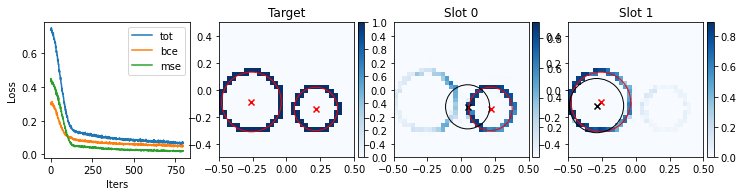

iter 900 , loss 0.060602605 , lr 0.000248984269942772


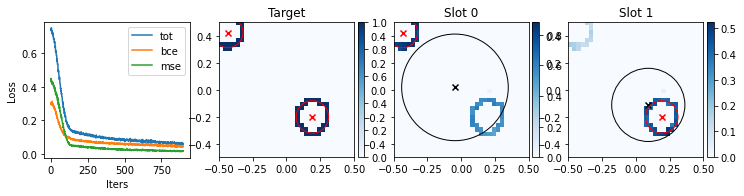

iter 1000 , loss 0.054540586 , lr 0.0002713525491562421


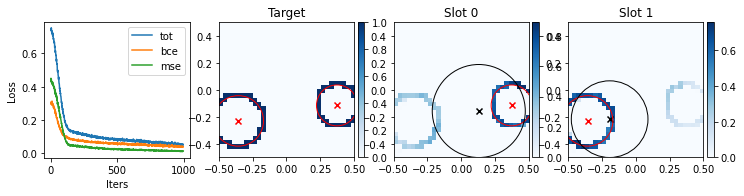

iter 1100 , loss 0.049100533 , lr 0.00026557698641636835


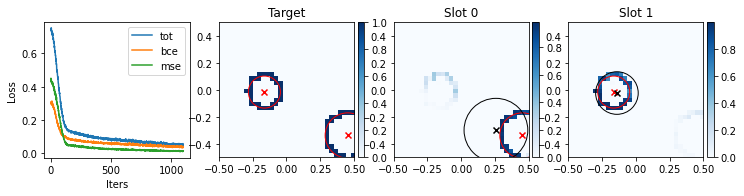

iter 1200 , loss 0.04319444 , lr 0.0002593452941132117


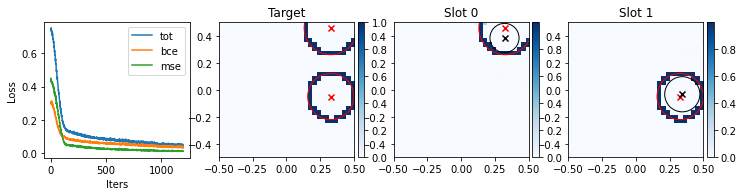

iter 1300 , loss 0.037931338 , lr 0.0002526820658893033


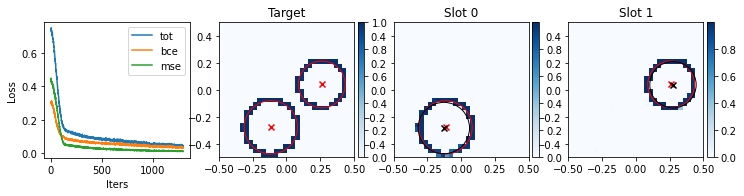

iter 1400 , loss 0.046078455 , lr 0.0002456135984623034


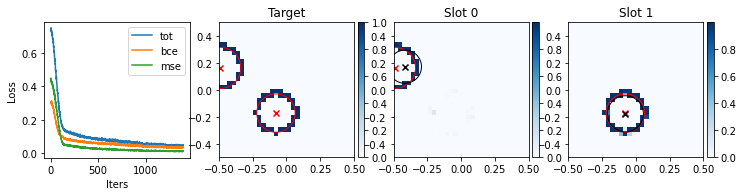

iter 1500 , loss 0.040018838 , lr 0.00023816778784387094


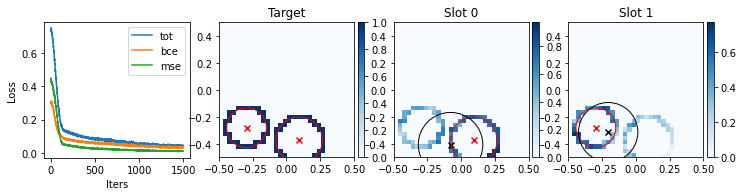

iter 1600 , loss 0.037138596 , lr 0.00023037401924684946


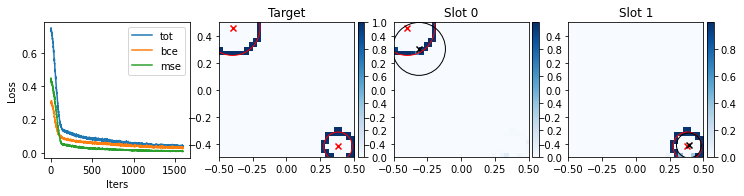

iter 1700 , loss 0.03810218 , lr 0.00022226305111525726


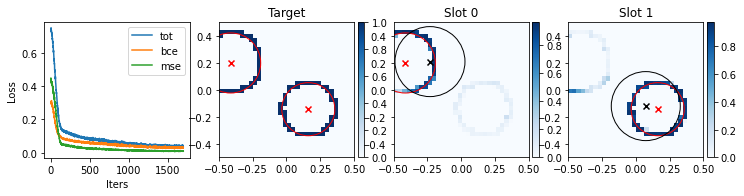

iter 1800 , loss 0.039481577 , lr 0.00021386689373476087


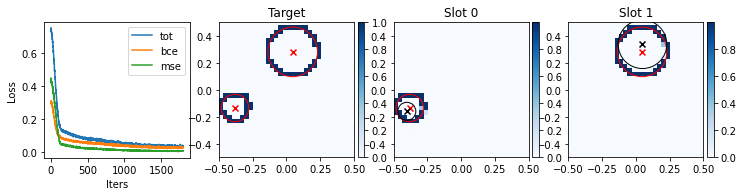

iter 1900 , loss 0.03620898 , lr 0.00020521868290270166


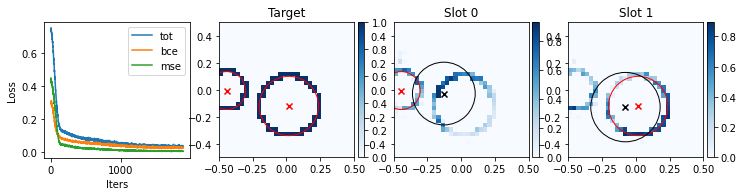

iter 2000 , loss 0.03160212 , lr 0.0001963525491562421


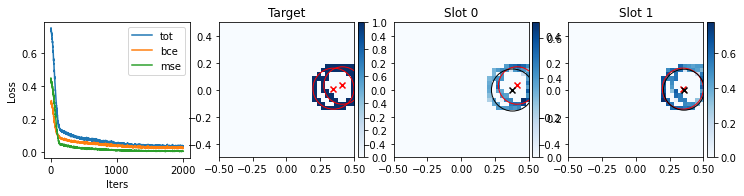

iter 2100 , loss 0.03042217 , lr 0.0001873034830747282


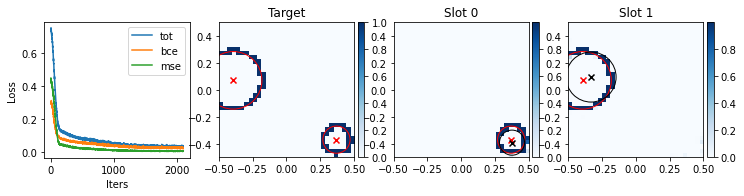

iter 2200 , loss 0.034530148 , lr 0.0001781071971878587


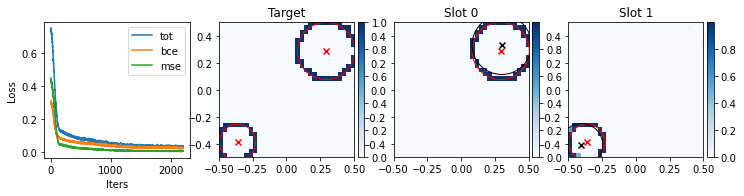

iter 2300 , loss 0.032604687 , lr 0.00016879998503464567


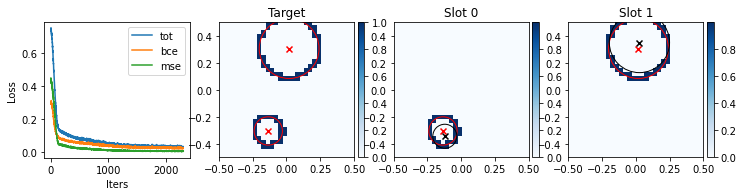

iter 2400 , loss 0.034738634 , lr 0.000159418577929397


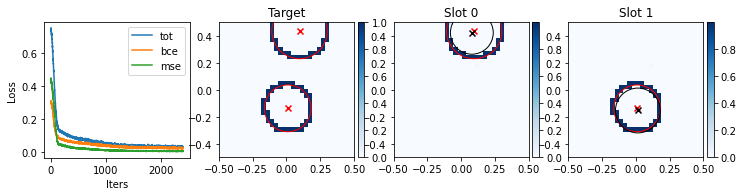

iter 2500 , loss 0.03188587 , lr 0.00015


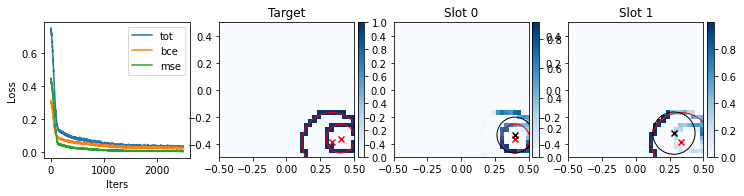

iter 2600 , loss 0.035062414 , lr 0.00014058142207060302


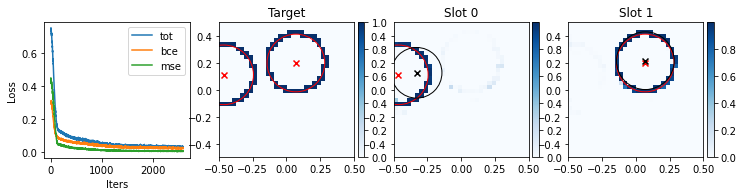

iter 2700 , loss 0.0323173 , lr 0.00013120001496535433


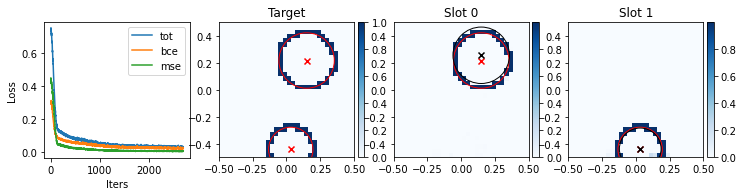

iter 2800 , loss 0.03129174 , lr 0.00012189280281214133


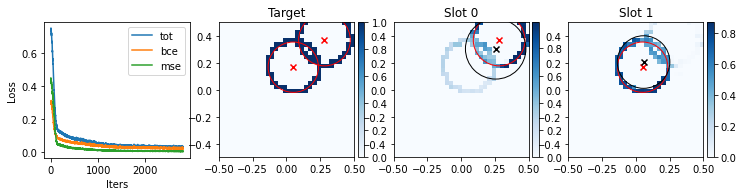

iter 2900 , loss 0.031365752 , lr 0.0001126965169252718


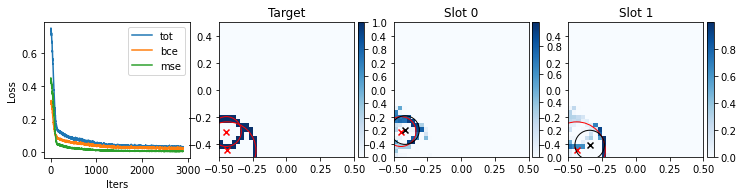

iter 3000 , loss 0.025128728 , lr 0.0001036474508437579


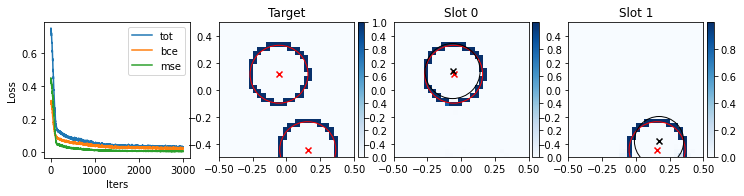

iter 3100 , loss 0.029303303 , lr 9.47813170972983e-05


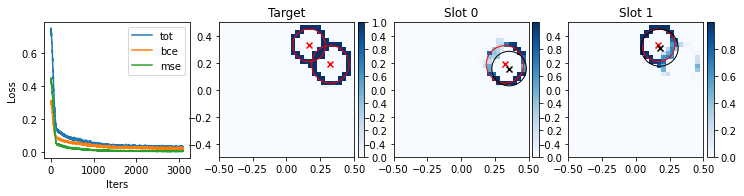

iter 3200 , loss 0.029146012 , lr 8.613310626523909e-05


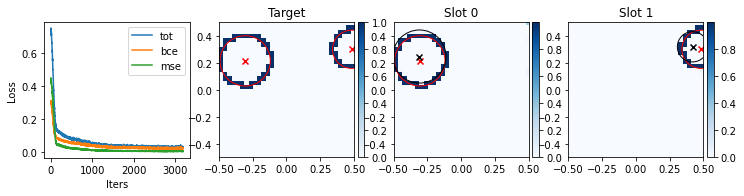

iter 3300 , loss 0.028777912 , lr 7.773694888474267e-05


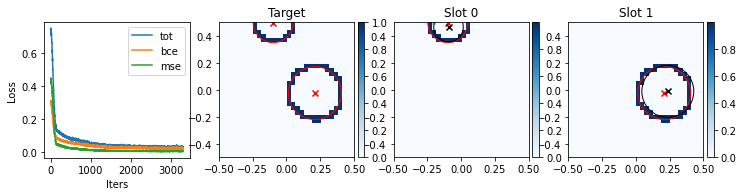

iter 3400 , loss 0.029979521 , lr 6.962598075315052e-05


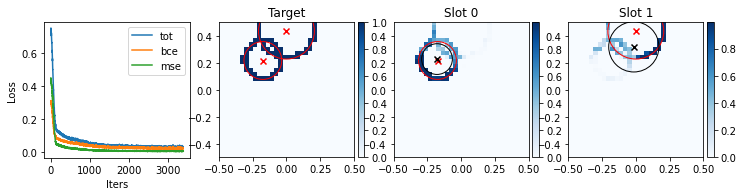

iter 3500 , loss 0.027316751 , lr 6.183221215612904e-05


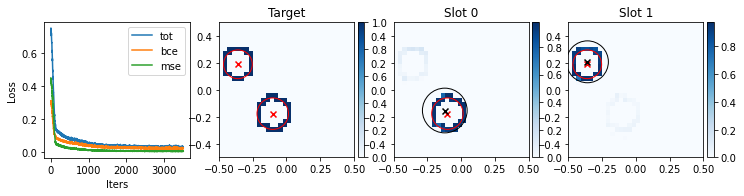

iter 3600 , loss 0.027421363 , lr 5.4386401537696536e-05


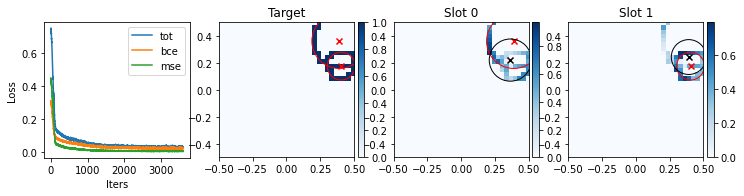

iter 3700 , loss 0.025796738 , lr 4.7317934110696685e-05


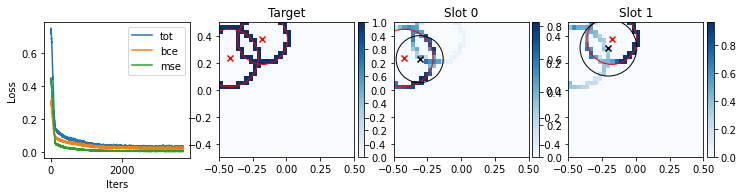

iter 3800 , loss 0.027044263 , lr 4.0654705886788245e-05


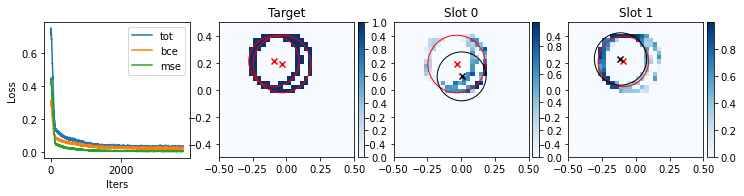

iter 3900 , loss 0.032066647 , lr 3.4423013583631594e-05


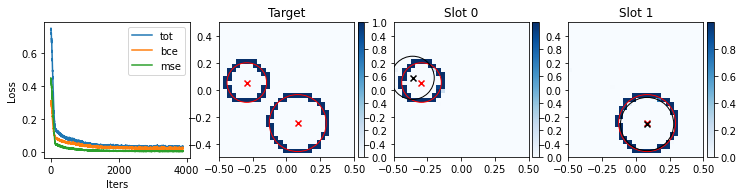

iter 4000 , loss 0.029201187 , lr 2.8647450843757897e-05


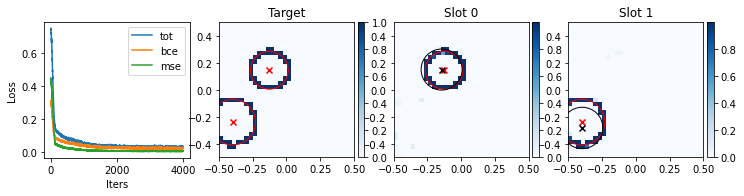

iter 4100 , loss 0.033755366 , lr 2.3350811174697737e-05


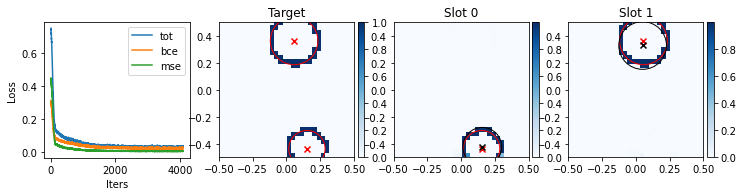

iter 4200 , loss 0.034575522 , lr 1.855399799342046e-05


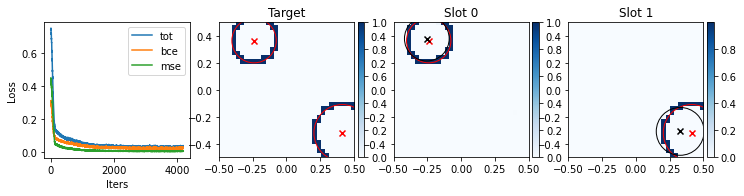

iter 4300 , loss 0.037772406 , lr 1.4275942130097096e-05


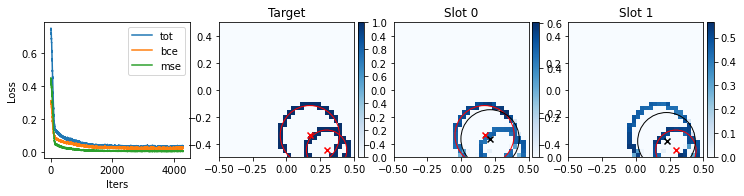

iter 4400 , loss 0.03100981 , lr 1.0533527116762296e-05


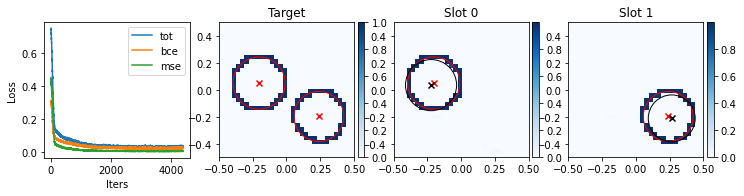

iter 4500 , loss 0.030495793 , lr 7.34152255572697e-06


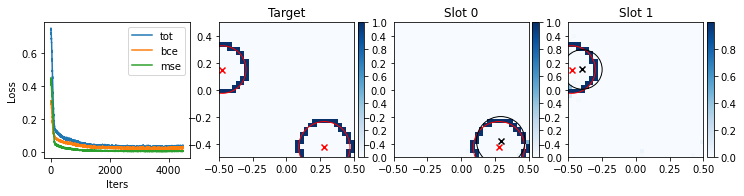

iter 4600 , loss 0.030898377 , lr 4.712525830705355e-06


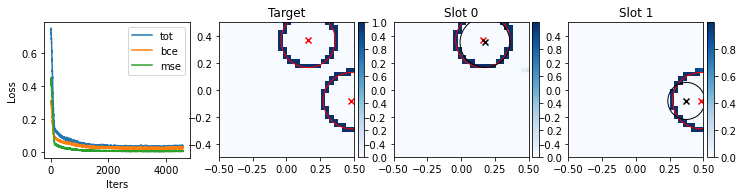

iter 4700 , loss 0.03441013 , lr 2.656912390696708e-06


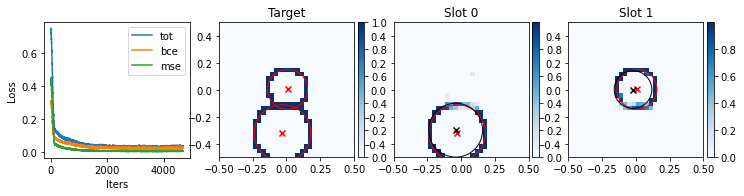

iter 4800 , loss 0.03461355 , lr 1.1827948028283352e-06


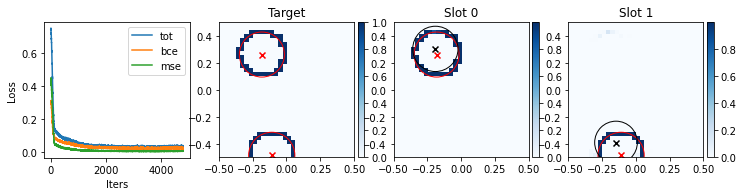

iter 4900 , loss 0.03200378 , lr 2.959907357592661e-07


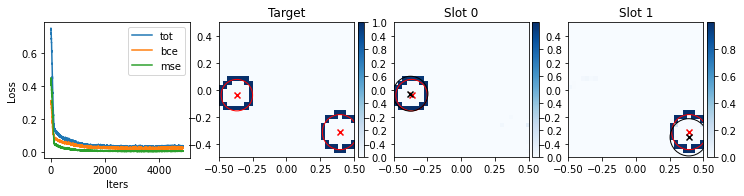

iter 5000 , loss 0.03372953 , lr 0.0


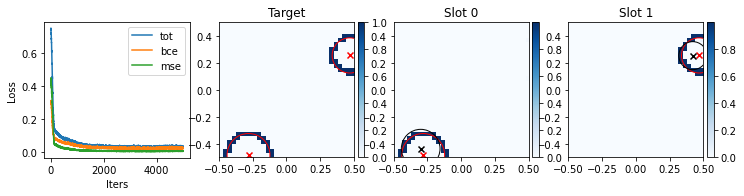

In [15]:
m, losses = train(m, bs=256, Ntrain=5_000, warmup_steps=1_000,
                  plot_every=100, device=device)#,
                  # modelDir=modelDir, figDir=figDir)

I had originally forgotten to save the model and figures, so I'll try saving them now :)

In [22]:
torch.save(m.state_dict(), f'{modelDir}/m_5000.pt')
with open(f'{modelDir}/loss.json','w') as f:
    json.dump(losses, f)

**Notes:**
- This loss seems lower than it was before (which I'm _super_ happy about).
- However, maybe I should do the Hungarian matching just based on the ...

In [28]:
pd.Series(losses['bce']).rolling(100).mean().tail()

4995    0.025876
4996    0.025843
4997    0.025855
4998    0.025839
4999    0.025855
dtype: float64

**Goal:** Let's try to compare these predictions on the same 100 examples that I was looking at in the `KL-divergence` notebook.

In [29]:
# Set numpy seed for test set sampling 
np.random.seed(24082023)

torch_seed = 29082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

In [66]:
bs = 100
kwargs={'isRing': True, 'N_clusters':2} #, 'device':device}

X,Y, mask = make_batch(N_events=bs, **kwargs)

In [56]:
max_n_rings = kwargs['N_clusters']
k_slots=max_n_rings+1
resolution=(32,32)

In [57]:
alpha=1

In [58]:
# with torch.no_grad():

#     queries, att, Y_pred = m(X)
         
#     # Reshape the target mask to be flat in the pixels (same shape as att)
#     flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      

#     pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
#     indices = hungarian_matching(pairwise_cost)

#     # Apply the sorting to the predict
#     bis=torch.arange(bs).to(device)
#     indices=indices.to(device)

#     # Loss calc
#     slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
#     rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
#     l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()

#     Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
#     Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

#     l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean()


In [63]:
m.device='cpu'
m = m.to('cpu')

In [70]:
hps['device'] = 'cpu'

In [78]:
m2 = InvariantSlotAttention(**hps)
m2.load_state_dict(torch.load(f'{modelDir}/m_5000.pt',map_location='cpu'))

<All keys matched successfully>

In [80]:
queries, att, Y_pred = m2(X)

In [81]:
with torch.no_grad():
    # Reshape the target mask to be flat in the pixels (same shape as att)
    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      
    with torch.no_grad():

        pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
        indices = hungarian_matching(pairwise_cost)

    # Apply the sorting to the predict
    bis=torch.arange(bs).to(device)
    indices=indices.to(device)

    # Loss calc
    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()

    Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean()


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100, 1, 2, 3])) that is different to the input size (torch.Size([100, 3, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [83]:
l_bce,l_mse

(tensor(0.2968), tensor(0.0731))

In [52]:
q,att, Y_pred = m(X)

RuntimeError: CUDA out of memory. Tried to allocate 150.00 MiB (GPU 0; 10.92 GiB total capacity; 7.82 GiB already allocated; 85.44 MiB free; 9.96 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [43]:
l_bce

tensor(0.3056, device='cuda:0')

In [44]:
l_mse

tensor(0.0599, device='cuda:0')

iEvt 0


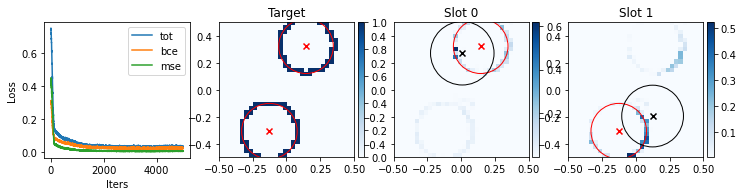

iEvt 1


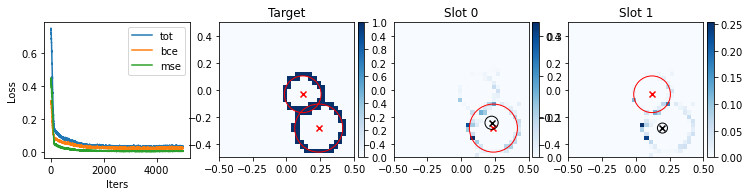

In [48]:
for iEvt in range(2):
# ,bce_i,mse_i in enumerate(zip(l_bce,l_mse)):

    print('iEvt',iEvt)#,', bce',bce_i,'mse',mse_i)  
       
    # losses, mask, att_img, Y_true, Y_pred
    plot_chosen_slots(losses,
                      mask[iEvt].sum(axis=0), 
                      slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                      Y_true_sorted[iEvt],
                      Y_pred_sorted[iEvt])